<a href="https://colab.research.google.com/github/chaitunitw/DSA_SYSTEM_DESIGN/blob/main/NVIDIA_cuOpt_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NVIDIA cuOpt: GPU-Accelerated Optimization

AMPL Minimal Example using [NVIDIA cuOpt](https://dev.ampl.com/solvers/cuopt/index.html). NVIDIA cuOpt is now [open-source](https://developer.nvidia.com/blog/accelerate-decision-optimization-using-open-source-nvidia-cuopt/) and available through AMPL! cuOpt leverages the speed of NVIDIA's GPU processors to achieve unprecedented speedups on very-large-scale linear and mixed-integer optimization problems.

📊 [Streamlit Apps](https://ampl.com/streamlit/) | 💻 [AMPL Colab Examples](https://ampl.com/colab/) | 📚 [MO-Book: AMPL+Python Book](https://ampl.com/mo-book/)

In [ ]:
# The only 3 lines you need to install and use AMPL with any solver on Colab
%pip install -q amplpy
from amplpy import AMPL, ampl_notebook

ampl = ampl_notebook(
    modules=["cuopt"],  # modules to install
    license_uuid="your-license-uuid",  # license to use
)  # instantiate AMPL object and register magics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 53.3 MB/s eta 0:00:00


In [ ]:
!nvidia-smi

Wed Jun 11 12:48:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import pandas as pd
# Power plant characteristics and demand profile
power_plants = df = pd.DataFrame({
    "Capacity_MW": [500, 600, 400, 450, 1000, 200, 300],
    "Cost_per_MW": [50, 55, 40, 42, 30, 0, 0],  # Solar & Wind have no fuel cost
    "CO2_Emission_per_MW": [1.2, 1.1, 0.5, 0.4, 0, 0, 0],  # Carbon emissions per MW
    "Ramp_Rate": [100, 120, 80, 90, 50, 300, 400],  # Max MW change per hour
}, index=["Coal_1", "Coal_2", "Gas_1", "Gas_2", "Nuclear_1", "Solar_1", "Wind_1"])
demand = pd.DataFrame({
    "Demand_MW": [800, 750, 700, 680, 660, 700, 850, 1000, 1200, 1300, 1400, 1350,
                  1250, 1150, 1100, 1080, 1050, 1100, 1150, 1200, 1300, 1200, 1000, 900]
}, index=range(24))

In [ ]:
%%writefile power.mod
# Model Author: ChatGPT
set PLANTS;
set HOURS;
param Capacity{PLANTS};
param Cost{PLANTS};
param CO2_Emission{PLANTS};
param Demand{HOURS};
param RampRate{PLANTS};

var Gen{PLANTS, HOURS} >= 0;

# Objective: Minimize cost while considering emissions
minimize TotalCost:
    sum {p in PLANTS, t in HOURS} Cost[p] * Gen[p,t];

# Meet demand with 10% spinning reserve
subject to MeetDemand {t in HOURS}:
    sum {p in PLANTS} Gen[p,t] >= 1.1 * Demand[t];

# Enforce capacity limits
subject to CapacityLimit {p in PLANTS, t in HOURS}:
    Gen[p,t] <= Capacity[p];

# Ramp rate constraint (except for first hour)
subject to RampConstraint {p in PLANTS, t in HOURS: t > 1}:
    abs(Gen[p,t] - Gen[p,t-1]) <= RampRate[p];

# Solar and Wind availability constraints
subject to SolarConstraint {t in HOURS: t < 6 or t > 18}:
    Gen["Solar_1", t] = 0;
subject to WindConstraint {t in HOURS}:
    Gen["Wind_1", t] <= 300;

Writing power.mod


In [ ]:
ampl = AMPL()
# Load the model
ampl.read("power.mod")
# Load pandas data into AMPL
ampl.set["PLANTS"] = power_plants.index
ampl.set["HOURS"] = demand.index
ampl.param["Capacity"] = power_plants["Capacity_MW"]
ampl.param["Cost"] = power_plants["Cost_per_MW"]
ampl.param["CO2_Emission"] = power_plants["CO2_Emission_per_MW"]
ampl.param["Demand"] = demand["Demand_MW"]
ampl.param["RampRate"] = power_plants["Ramp_Rate"]
# Solve with NVIDIA CUOPT using GPU-accelerated algorithms
ampl.solve(solver="cuopt", cuopt_options="outlev=1")
assert ampl.solve_result == "solved"
# Extract results into a pandas dataframe
generation = ampl.var["Gen"].to_pandas()
prices = ampl.get_data("MeetDemand.dual").to_pandas()

CUOPT 25.5.0: Setting parameter log_to_console to true
  tech:outlev = true
Solving a problem with 604 constraints 447 variables (0 integers) and 1315 nonzeros
Objective offset 0.000000 scaling_factor 1.000000
Running concurrent

Dual simplex finished in 0.01 seconds
   Iter    Primal Obj.      Dual Obj.    Gap        Primal Res.  Dual Res.   Time
      0 +0.00000000e+00 +0.00000000e+00  0.00e+00   5.71e+03     0.00e+00   0.092s
PDLP finished
Concurrent time:  0.095s
Solved with dual simplex
Status: Optimal   Objective: 5.49930000e+05  Iterations: 227  Time: 0.095s
CUOPT 25.5.0: optimal; objective 549930


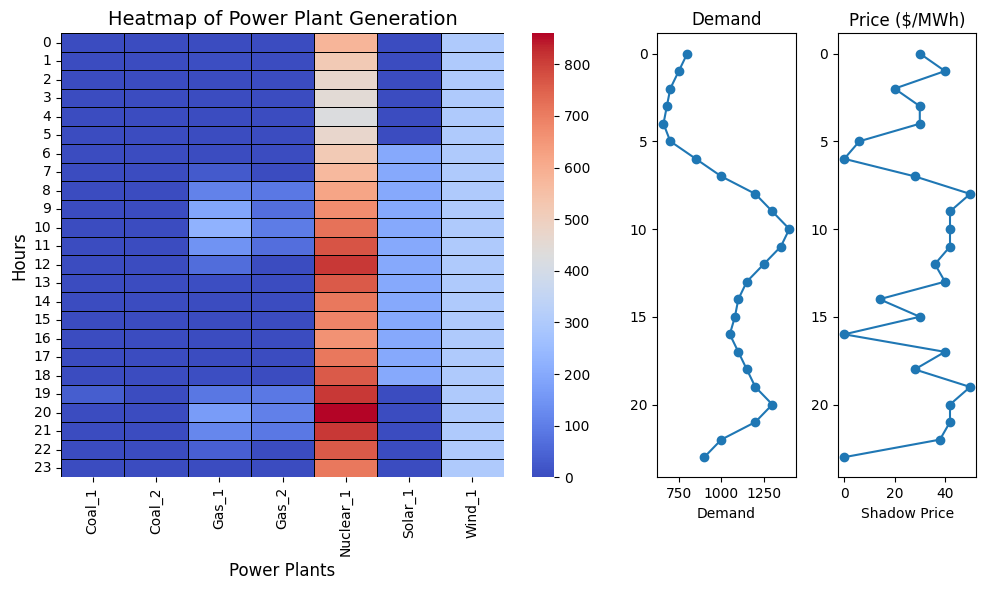

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(10, 6), gridspec_kw={'width_ratios': [8, 2, 2]})

# Plot Power Generation Heatmap
df = generation.unstack()
df.columns = df.columns.droplevel(0)
ax = sns.heatmap(df.T, ax=ax1, annot=False, fmt=".1f", cmap="coolwarm", linewidths=0.5, linecolor="black")
ax1.set_title("Heatmap of Power Plant Generation", fontsize=14)
ax1.set_xlabel("Power Plants", fontsize=12)
ax1.set_ylabel("Hours", fontsize=12)
ax1.tick_params(axis="x", rotation=90)
ax1.tick_params(axis="y", rotation=0)

# Plot Demand Line Chart
ax2.plot(demand.values, demand.index, marker='o')
ax2.set_title("Demand", fontsize=12)
ax2.set_xlabel("Demand")
ax2.set_ylabel("")
ax2.invert_yaxis()

# Plot Price Line Chart
ax3.plot(prices.values, prices.index, marker='o')
ax3.set_title("Price ($/MWh)", fontsize=12)
ax3.set_xlabel("Shadow Price")
ax3.set_ylabel("")
ax3.invert_yaxis()

plt.tight_layout()
plt.show()

🔍 **Learn More:**
- 🔗 [AMPL Website](https://ampl.com)
- 🚀 [Start Free Now!](https://ampl.com/trial/)
- 💼 [Follow us on LinkedIn!](https://www.linkedin.com/company/ampl)

💡 **More Examples:**
- 📊 [Streamlit Apps](https://ampl.com/streamlit/)  
- 💻 [AMPL Colab Examples](https://ampl.com/colab/)  
- 📚 [MO-Book: AMPL+Python Book](https://ampl.com/mo-book/)  

📢 **Breaking Barriers in Optimization:**  
- Read more about our [collaboration with NVIDIA 🚀](https://ampl.com/blog/breaking-barriers-in-optimization-ampls-early-results-with-nvidia-cuopt/)!

[![Powered By AMPL](https://h.ampl.com/https://ampl.com/cuOpt)](https://ampl.com)